In [1]:
import pulp
import networkx as nx

# Data

In [2]:
n=10

In [3]:
T = [
    [0 for _ in range(n)]
    for _ in range(n)
]

In [4]:
T

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [7]:
cells = [(i,j) for i in range(len(T)) for j in range(len(T))]
#cells

In [8]:
neighbours = {}
for (i,j) in cells:
    #neighbours[(i,j)] = [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]
    neighbours[(i,j)] = [(i+k,j+h) for k in [-1,0,1] for h in [-1,0,1] if k+h!=0 and k*h!=1 and i+k>=0 and i+k<len(T) and j+h>=0 and j+h<len(T) ]
neighbours

{(0, 0): [(0, 1), (1, 0)],
 (0, 1): [(0, 0), (0, 2), (1, 1)],
 (0, 2): [(0, 1), (0, 3), (1, 2)],
 (0, 3): [(0, 2), (0, 4), (1, 3)],
 (0, 4): [(0, 3), (0, 5), (1, 4)],
 (0, 5): [(0, 4), (0, 6), (1, 5)],
 (0, 6): [(0, 5), (0, 7), (1, 6)],
 (0, 7): [(0, 6), (0, 8), (1, 7)],
 (0, 8): [(0, 7), (0, 9), (1, 8)],
 (0, 9): [(0, 8), (1, 9)],
 (1, 0): [(0, 0), (1, 1), (2, 0)],
 (1, 1): [(0, 1), (1, 0), (1, 2), (2, 1)],
 (1, 2): [(0, 2), (1, 1), (1, 3), (2, 2)],
 (1, 3): [(0, 3), (1, 2), (1, 4), (2, 3)],
 (1, 4): [(0, 4), (1, 3), (1, 5), (2, 4)],
 (1, 5): [(0, 5), (1, 4), (1, 6), (2, 5)],
 (1, 6): [(0, 6), (1, 5), (1, 7), (2, 6)],
 (1, 7): [(0, 7), (1, 6), (1, 8), (2, 7)],
 (1, 8): [(0, 8), (1, 7), (1, 9), (2, 8)],
 (1, 9): [(0, 9), (1, 8), (2, 9)],
 (2, 0): [(1, 0), (2, 1), (3, 0)],
 (2, 1): [(1, 1), (2, 0), (2, 2), (3, 1)],
 (2, 2): [(1, 2), (2, 1), (2, 3), (3, 2)],
 (2, 3): [(1, 3), (2, 2), (2, 4), (3, 3)],
 (2, 4): [(1, 4), (2, 3), (2, 5), (3, 4)],
 (2, 5): [(1, 5), (2, 4), (2, 6), (3, 5)],
 (

In [9]:
len(T)**2

100

In [10]:
positions = [k for k in range(1,len(T)**2+1)]

# MIP

In [11]:
# create problem
prob = pulp.LpProblem("cycle", pulp.LpMaximize)

# define variables
x = pulp.LpVariable.dicts("x",(cells,positions),cat=pulp.LpBinary)

# objective function
prob += 0

# each cell has a unique number
for (i,j) in cells:
    prob += pulp.lpSum(x[(i,j)][k] for k in positions) == 1

# each position is used once
for k in positions:
    prob += pulp.lpSum(x[(i,j)][k] for (i,j) in cells) == 1
    
# contiguity
for (i,j) in cells:
    for k in positions:
        if k<len(T)**2:
            prob += x[(i,j)][k] <= pulp.lpSum(x[(u,v)][k+1] for (u,v) in neighbours[(i,j)]) 
        else:
            prob += x[(i,j)][k] <= pulp.lpSum(x[(u,v)][1] for (u,v) in neighbours[(i,j)])

In [76]:
#prob

In [13]:
prob.solve(pulp.GUROBI_CMD(timeLimit=60))

1

In [14]:
Tsol=T.copy()

In [15]:
for (i,j) in cells:
    for k in positions:
        val = pulp.value(x[(i,j)][k])
        if val >0.9:
            # print(i,j,"-->",k)
            Tsol[i][j]=k
#Tsol

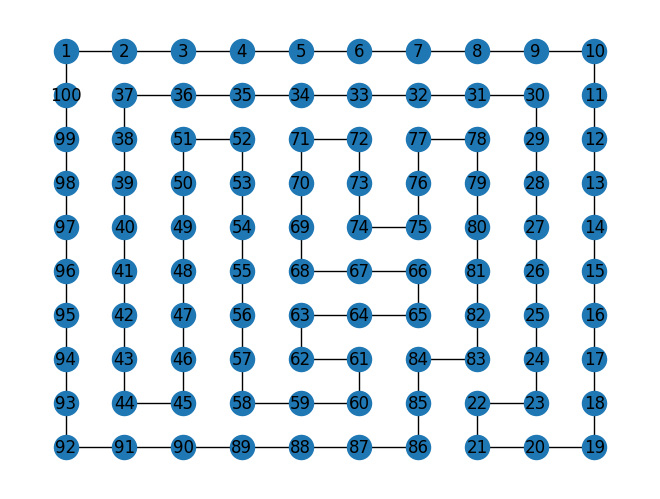

In [16]:
G=nx.grid_2d_graph(len(T),len(T))
for v in G.nodes():
    G.nodes[v]["layer"]=v[0]
    val = T[v[1]][v[0]]
    if val > 0:
        G.nodes[v]["value"]=val
    else:
        G.nodes[v]["value"]=""
edges_to_delete = []
for (u,v) in G.edges():
    if abs(G.nodes[v]["value"]-G.nodes[u]["value"])>1 and abs(G.nodes[v]["value"]-G.nodes[u]["value"])!=len(T)**2-1:
        edges_to_delete.append((u,v))
G.remove_edges_from(edges_to_delete)
nx.draw(G,
        pos=nx.multipartite_layout(G,subset_key="layer"),
        labels = nx.get_node_attributes(G, 'value') )